What if the same null basis worked for multiple lines in the network? I may be recomputing something that isn't changing. Since this is the most computationally demanding step in the process, and since it is also the first step, I may be able to store the result from one QCQP for use in the next.

To test this hypothesis, I will generate the set of $A$ matrices for the RTS-96 network. I will compute a null basis $B$ for the first one and see whether $AB = 0$ for any remaining $A$ matrices.

[Later in the day] Okay, I did that and it didn't work out. One null basis does not work for all $A$ matrices. Why not? Is there a single basis that will work for all $A$ matrices? Can I reuse most of the basis and update only a small part? 


# Split null basis computation
By exploiting the structure of the $A$ matrix, it is possible to compute a matrix $B_1$ that may be reused for every line in the network. For each individual line, $n_t$ additional rows $B_2$ are computed so that $[B_1;B_2]$ forms a null basis for $A$. Not only does reusing $B_1$ save time, but $B_2$ is computed using only a sparse matrix multiplication (a cheap operation). Switching to this new null basis approach yields a speedup of forty percent for the algorithm overall. The remainder of this report details the new approach.

Most of the $A$ matrix is invariant with respect to which line the temporal instanton QCQP is focusing on. I refer to the fixed but network-dependent part as $A_1$, and the remaining part as $A_2$. Only $A_2$ changes from one line to the next. The $A$ matrix overall takes the following form:

$$
\begin{align}
A &= \begin{bmatrix} A_1 & 0 \\ A_2 & I \end{bmatrix},
\end{align}
$$
where $A_1$ contains the admittance matrix, participation factors, and decision variable coefficients, and $A_2$ defines auxiliary angle variables in terms of voltage angle differences. When moving from one line to the next, $A_2$ is updated to connect auxiliary angle variables to the proper nodal voltage angles. All other elements of $A$ are unaltered.

A null basis for $A$ is any matrix $B$ that satisfies the following condition:

$$
\begin{align}
AB &= 0 \\
\iff \begin{bmatrix}  A_1 & 0 \\ A_2 & I \end{bmatrix} \begin{bmatrix} B_1 \\ B_2 \end{bmatrix} &= 0 \\
\iff \begin{cases} A_1 B_1 &= 0 \\ B_2 &= -A_2 B_1 \end{cases}
\end{align}
$$

Observe that $B_1$ is a function of $A_1$ only. Because $A_1$ does not depend on the chosen line, $B_1$ may be computed outside the line loop. For an individual line, $B_2$ may be computed by multiplying $A_2$ and $B_1$. Stacking $B_1$ atop $B_2$ yields a matrix $B$ such that $AB = 0$, as desired.

The computational cost of this approach is one $(n_b+n_r+1)n_t$-by-$(n_b+1)n_t$ sparse QR decomposition plus $n_l$ (number of lines) sparse matrix multiplications, each with greatest dimension $(n_b + n_r + 1)n_t$. The figure below illustrates the effect of switching from the previous approach (performing a sparse QR decomposition for each line) to the new approach:

![](../images/2015-12-07-timing-analysis-reuse-temp.png)
![](../images/2016-01-19-timing-analysis-split-null-basis.png)

The speedup is roughly forty percent.

Note that the "after" figure does not account for the time taken to compute $B_1$, since that step is now performed outside the line loop. An upper bound on the computation of $B_1$ is forty-five percent of a single QCQP solution 

In [1]:
include("../src/TemporalInstanton.jl")
using TemporalInstanton
d = testcase("timing")

TemporalInstanton.InstantonInputData([2,14,16,17,18,19,20,21,23,26,36,37,43,44,47,49,54,57],73x73 sparse matrix with 289 Float64 entries:
	[1 ,  1]  =  -87.9326
	[2 ,  1]  =  71.4286
	[3 ,  1]  =  4.73934
	[5 ,  1]  =  11.7647
	[1 ,  2]  =  71.4286
	[2 ,  2]  =  -84.5109
	[4 ,  2]  =  7.87402
	[6 ,  2]  =  5.20833
	[1 ,  3]  =  4.73934
	[3 ,  3]  =  -25.0475
	⋮
	[60, 71]  =  10.3093
	[61, 71]  =  11.4943
	[68, 71]  =  90.9091
	[71, 71]  =  -223.824
	[73, 71]  =  111.111
	[51, 72]  =  11.9048
	[63, 72]  =  19.2308
	[72, 72]  =  -31.1355
	[21, 73]  =  10.3093
	[71, 73]  =  111.111
	[73, 73]  =  -121.42,[1.204,1.204,0.0,0.0,0.0,0.0,1.12,0.56,0.0,0.0  …  1.085,0.0,2.8,0.0,0.0,2.8,2.1,4.62,0.0,0.0],[0.636042,0.56909,1.05449,0.435186,0.418448,0.803421,0.736469,1.00428,1.02101,1.13818  …  0.585828,0.0,1.95834,1.07123,0.753207,0.0,0.0,0.0,0.0,0.0],[0.0,0.0820657,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],1.0e8,1,[(1,2),(1,3),(1,5),(2,4),(2,6),(3,9),(3,24),(4,9

In [5]:
@time o = solve_temporal_instanton(d)
sort(o.score)

r=0 check: 	removing 1 lines
  0.833631 seconds (338.88 k allocations: 303.096 MB, 3.22% gc time)


104-element Array{Tuple{Float64,Int64},1}:
 (0.2637877341996323,25) 
 (0.3273167532507126,30) 
 (1.2886116742568396,69) 
 (2.2041515569549324,89) 
 (2.3229739172398833,118)
 (2.4231613461834343,64) 
 (4.678758530519555,42)  
 (4.865240026220744,102) 
 (4.899167747804743,31)  
 (5.678275094502421,80)  
 (5.938614653209734,1)   
 (6.4391722152056285,100)
 (6.460889177817809,62)  
 ⋮                       
 (178.085263594121,99)   
 (303.00092576608984,103)
 (370.6118288841749,67)  
 (370.61182888417574,66) 
 (391.3068338497743,33)  
 (428.94292075306737,40) 
 (923.9909510647706,72)  
 (979.1908687267133,117) 
 (1319.8492876743082,79) 
 (1390.0600720226919,110)
 (1967.2796760965095,74) 
 (1967.2796760965098,73) 

r=0 check: 	removing 1 lines


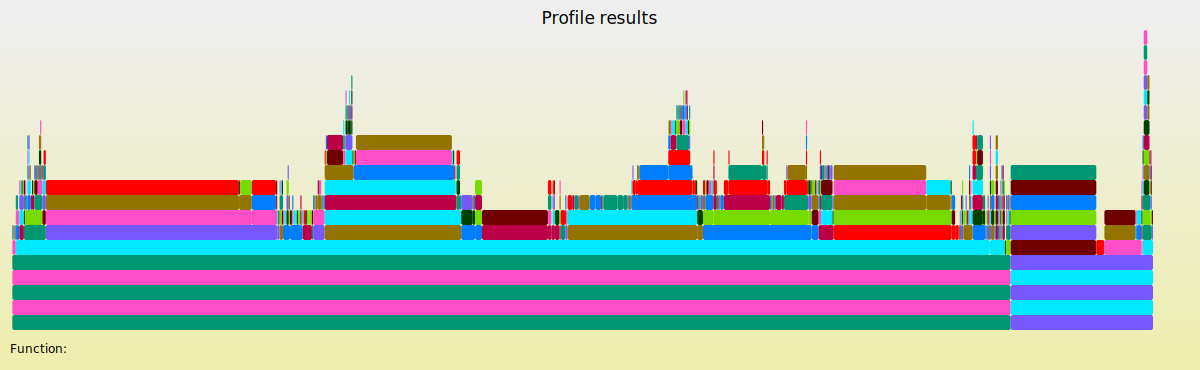

In [33]:
Profile.clear()
@profile solve_temporal_instanton(d)
# Profile.print()

using ProfileView
ProfileView.view()

In [5]:
using JLD
B = load("../data/N.jld","N")

558x108 sparse matrix with 9936 Float64 entries:
	[1  ,   1]  =  -0.0659819
	[2  ,   1]  =  -0.0149391
	[3  ,   1]  =  -0.0253067
	[4  ,   1]  =  -0.0341505
	[5  ,   1]  =  -0.0383026
	[6  ,   1]  =  -0.00933216
	[7  ,   1]  =  0.00460869
	[8  ,   1]  =  -0.0421905
	[9  ,   1]  =  0.0123302
	[10 ,   1]  =  -0.163301
	⋮
	[543, 108]  =  0.0168722
	[544, 108]  =  0.0170614
	[545, 108]  =  0.0153986
	[546, 108]  =  0.0144622
	[547, 108]  =  0.0170016
	[548, 108]  =  0.0170548
	[549, 108]  =  0.0139472
	[550, 108]  =  0.0172834
	[551, 108]  =  0.0129564
	[552, 108]  =  -0.0832252
	[558, 108]  =  -0.00128204

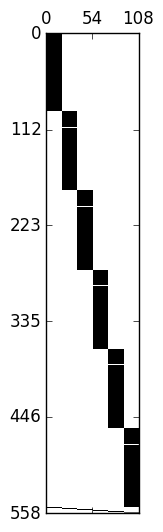

In [12]:
using PyPlot
PyPlot.svg(true)
spy(B)
yticks(int(linspace(0,size(B,1),6)))
xticks(linspace(0,size(B,2),3))
savefig("../images/2016-01-19-split-null-spy.pdf")